In [4]:
import numpy as np
import os
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [5]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(os.getcwd(),'dataset_labeled')
print(dir_base)

/home/ladans/DNN/Noise reduction
/home/ladans/DNN/Noise reduction/dataset_labeled


In [15]:
st = time.time()

# Load and preprocess images
dir_base = os.path.join(os.getcwd(),'dataset_labeled')
image_filenames = os.listdir(dir_base)
images = []

for image_name in image_filenames:
    img_path = os.path.join(dir_base, image_name)
    try:
        img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
        img = img.resize((128, 128))  # Resize to 128x128
        img_array = np.array(img)  # Normalize to [0, 1]
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

# Convert the list of images into a numpy array
images = np.array(images)
images = np.array(images) / 255.0

# Split the dataset into training and test sets (80% training, 20% test)
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

# Build the Denoising Autoencoder
# Input: 128x128x3
input_img = Input(shape=(128, 128, 3))

# Encoder
#First Conv2D + Pooling: 128x128x3 -> 64x64x64
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)# 64x64x64
# Second Conv2D + Pooling: 64x64x64 -> 32x32x128
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)# 32x32x128
# Third Conv2D + Pooling: 32x32x128 -> 16x16x256
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)# 16x16x256

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Build the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(train_images, train_images,  # Autoencoders use input = target
                epochs=60,
                batch_size=32,
                shuffle=True,
                validation_data=(test_images, test_images))

# Denoise the test set
denoised_images = autoencoder.predict(test_images)
#Convert to unsigned 8-bit integer type(denormalization)
test_images = test_images * 255
test_images = test_images.astype(np.uint8)
denoised_images = denoised_images * 255
denoised_images = denoised_images.astype(np.uint8) 


# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 933ms/step - loss: 0.0634 - val_loss: 0.0217
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 923ms/step - loss: 0.0184 - val_loss: 0.0140
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 914ms/step - loss: 0.0150 - val_loss: 0.0120
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 923ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 922ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 928ms/step - loss: 0.0104 - val_loss: 0.0091
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 922ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 923ms/step - loss: 0.0077 - val_loss: 0.0089
Epoch 9/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 909ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 10/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 915ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 11/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 921ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 12/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 33

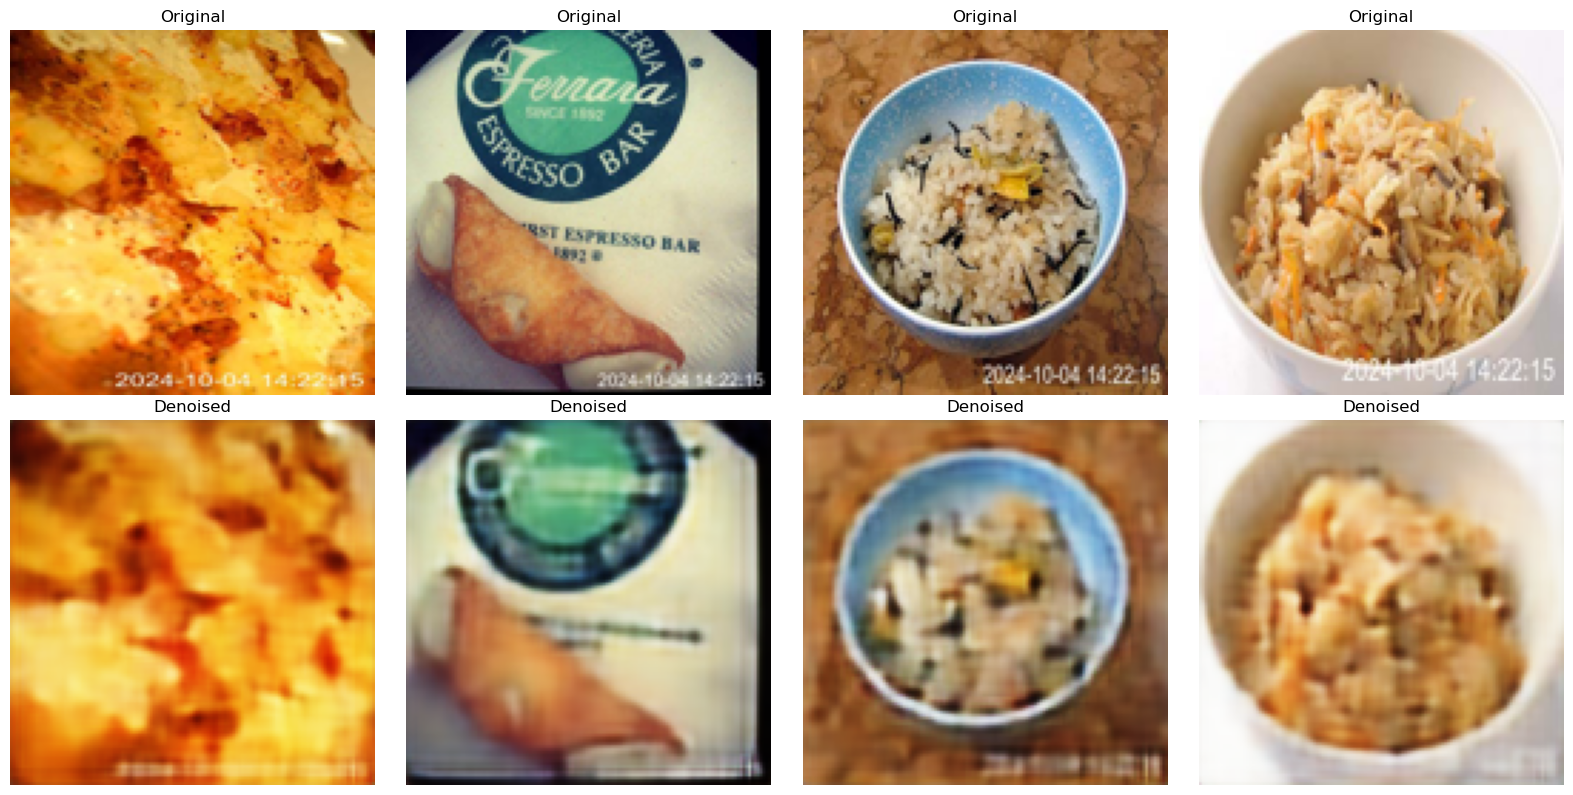

In [14]:
import matplotlib.pyplot as plt

# Number of images to display
n = 4

# Create the subplot layout with 2 rows and n columns
fig, axes = plt.subplots(2, n, figsize=(n * 4, 8))

# Add the original images to the first row
for i in range(n):
    axes[0, i].imshow(test_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

# Add the denoised images to the second row
for i in range(n):
    axes[1, i].imshow(denoised_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Denoised")

# Adjust layout to fit titles and images
plt.tight_layout()
plt.savefig('result_1')
plt.show()


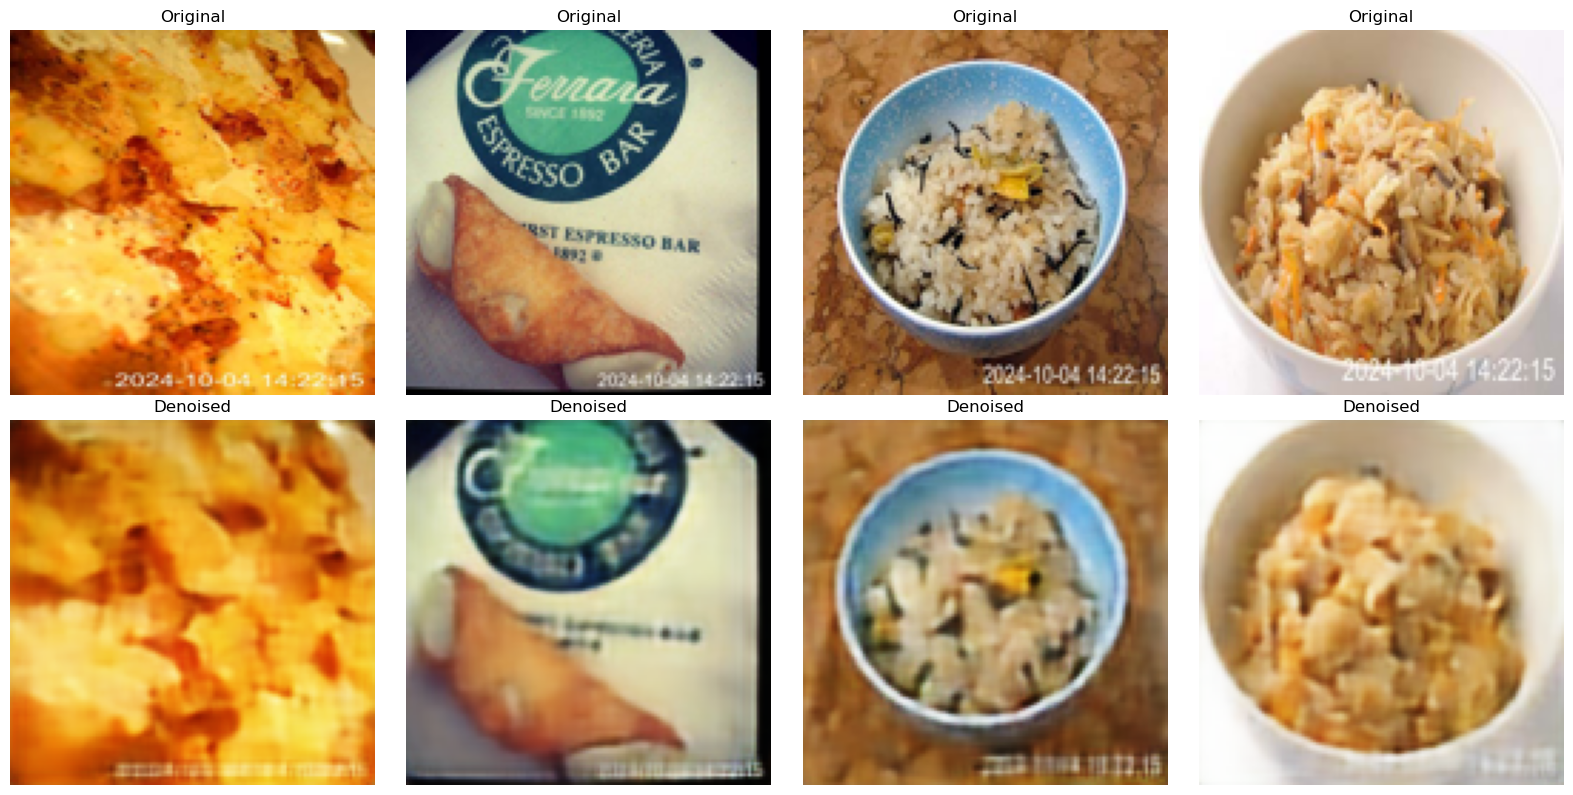

In [17]:
import matplotlib.pyplot as plt

# Number of images to display
n = 4

# Create the subplot layout with 2 rows and n columns
fig, axes = plt.subplots(2, n, figsize=(n * 4, 8))

# Add the original images to the first row
for i in range(n):
    axes[0, i].imshow(test_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

# Add the denoised images to the second row
for i in range(n):
    axes[1, i].imshow(denoised_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Denoised")

# Adjust layout to fit titles and images
plt.tight_layout()
plt.savefig('result_2')
plt.show()
